<h1>ACDC Main Demo</h1>

<p>This notebook (which doubles as a script) shows several use cases of ACDC</p>

<p>This codebase is a fork of https://github.com/neelnanda-io/TransformerLens with changes that will hopefully be merged soon</p>

<h3>Setup:</h3>
<p>Janky code to do different setup when run in a Colab notebook vs VSCode (adapted from e.g <a href="https://github.com/neelnanda-io/TransformerLens/blob/5c89b7583e73ce96db5e46ef86a14b15f303dde6/demos/Activation_Patching_in_TL_Demo.ipynb">this notebook</a>)</p>

In [1]:
try:
    import google.colab

    IN_COLAB = True
    print("Running as a Colab notebook")

    from IPython import get_ipython

    ipython = get_ipython()
    ipython.run_line_magic(
        "pip",
        "install git+https://github.com/neelnanda-io/TransformerLens.git", 
    )
    ipython.run_line_magic(
        "pip",
        "install git+https://github.com/ArthurConmy/Automatic-Circuit-Discovery.git",
    )
    ipython.run_line_magic("pip", "install torchtyping")
    ipython.run_line_magic("pip", "install cmapy")
    try:
        ipython.run_line_magic(
            "pip",
            "install git+https://github.com/deepmind/tracr.git@e75ecdaec12bf2d831a60e54d4270e8fa31fb537#egg=tracr",
        )
    except Exception as e:
        print(f"Could not import `tracr` because {e}; the rest of the file should work but you cannot use the tracr tasks")


except Exception as e:
    IN_COLAB = False
    print(
        "Running as a Jupyter notebook - intended for development only! (This is also used for automatically generating notebook outputs)"
    )

    import numpy # crucial to not get cursed error
    import plotly

    plotly.io.renderers.default = "colab"  # added by Arthur so running as a .py notebook with #%% generates .ipynb notebooks that display in colab
    # disable this option when developing rather than generating notebook outputs

    from IPython import get_ipython

    ipython = get_ipython()
    if ipython is not None:
        ipython.run_line_magic("load_ext", "autoreload")  # type: ignore
        ipython.run_line_magic("autoreload", "2")  # type: ignore

Running as a Jupyter notebook - intended for development only! (This is also used for automatically generating notebook outputs)


<h2>Imports etc</h2>

In [2]:
import wandb
import IPython
from IPython.display import Image, display
import torch
import gc
from tqdm import tqdm
import networkx as nx
import os
import torch
import huggingface_hub
import graphviz
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from tqdm import tqdm
import yaml
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from transformer_lens.hook_points import HookedRootModule, HookPoint
from acdc.acdc_graphics import show
from transformer_lens.HookedTransformer import (
    HookedTransformer,
)
try:
    from acdc.tracr_task.utils import (
        get_all_tracr_things,
        get_tracr_model_input_and_tl_model,
    )
except Exception as e:
    print(f"Could not import `tracr` because {e}; the rest of the file should work but you cannot use the tracr tasks")
from acdc.docstring.utils import get_all_docstring_things
from acdc.acdc_utils import (
    make_nd_dict,
    reset_network,
    shuffle_tensor,
    cleanup,
    ct,
    TorchIndex,
    Edge,
    EdgeType,
)  # these introduce several important classes !!!

from acdc.TLACDCCorrespondence import TLACDCCorrespondence
from acdc.TLACDCInterpNode import TLACDCInterpNode
from acdc.TLACDCExperiment import TLACDCExperiment

from acdc.acdc_utils import (
    kl_divergence,
)
from acdc.ioi.utils import (
    get_all_ioi_things,
    get_gpt2_small,
)
from acdc.induction.utils import (
    get_all_induction_things,
    get_validation_data,
    get_good_induction_candidates,
    get_mask_repeat_candidates,
)
from acdc.greaterthan.utils import get_all_greaterthan_things
from acdc.acdc_graphics import (
    build_colorscheme,
    show,
)
import argparse

torch.autograd.set_grad_enabled(False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<h2>ACDC Experiment Setup</h2>
<p>We use a `parser to set all the options for the ACDC experiment.
This is still usable in notebooks! We can pass a string to the parser, see below.
We'll reproduce </p>

In [3]:
parser = argparse.ArgumentParser(description="Used to launch ACDC runs. Only task and threshold are required")

task_choices = ['ioi', 'docstring', 'induction', 'tracr-reverse', 'tracr-proportion', 'greaterthan']
parser.add_argument('--task', type=str, required=True, choices=task_choices, help=f'Choose a task from the available options: {task_choices}')
parser.add_argument('--threshold', type=float, required=True, help='Value for THRESHOLD')
parser.add_argument('--first-cache-cpu', type=bool, required=False, default=True, help='Value for FIRST_CACHE_CPU')
parser.add_argument('--second-cache-cpu', type=bool, required=False, default=True, help='Value for SECOND_CACHE_CPU')
parser.add_argument('--zero-ablation', action='store_true', help='Use zero ablation')
parser.add_argument('--using-wandb', action='store_true', help='Use wandb')
parser.add_argument('--wandb-entity-name', type=str, required=False, default="remix_school-of-rock", help='Value for WANDB_ENTITY_NAME')
parser.add_argument('--wandb-group-name', type=str, required=False, default="default", help='Value for WANDB_GROUP_NAME')
parser.add_argument('--wandb-project-name', type=str, required=False, default="acdc", help='Value for WANDB_PROJECT_NAME')
parser.add_argument('--wandb-run-name', type=str, required=False, default=None, help='Value for WANDB_RUN_NAME')
parser.add_argument("--wandb-dir", type=str, default="/tmp/wandb")
parser.add_argument("--wandb-mode", type=str, default="online")
parser.add_argument('--indices-mode', type=str, default="normal")
parser.add_argument('--names-mode', type=str, default="normal")
parser.add_argument('--device', type=str, default="cuda")
parser.add_argument('--reset-network', type=int, default=0, help="Whether to reset the network we're operating on before running interp on it")
parser.add_argument('--metric', type=str, default="kl_div", help="Which metric to use for the experiment")
parser.add_argument('--torch-num-threads', type=int, default=0, help="How many threads to use for torch (0=all)")
parser.add_argument('--seed', type=int, default=1234)
parser.add_argument("--max-num-epochs",type=int, default=100_000)
parser.add_argument('--single-step', action='store_true', help='Use single step, mostly for testing')

if ipython is not None:
    # we are in a notebook
    # you can put the command you would like to run as the ... in r"""..."""
    args = parser.parse_args( # TODO add back zero ablation
        [line.strip() for line in r"""--task=induction\
--zero-ablation\
--threshold=0.0.5623\
--indices-mode=reverse\
--first-cache-cpu=False\
--second-cache-cpu=False\
--max-num-epochs=100000""".split("\\\n")]
    )
else:
    # read from command line
    args = parser.parse_args()

# process args

if args.torch_num_threads > 0:
    torch.set_num_threads(args.torch_num_threads)
torch.manual_seed(args.seed)

TASK = args.task
FIRST_CACHE_CPU = args.first_cache_cpu
SECOND_CACHE_CPU = args.second_cache_cpu
THRESHOLD = args.threshold  # only used if >= 0.0
ZERO_ABLATION = True if args.zero_ablation else False
USING_WANDB = True if args.using_wandb else False
WANDB_ENTITY_NAME = args.wandb_entity_name
WANDB_PROJECT_NAME = args.wandb_project_name
WANDB_RUN_NAME = args.wandb_run_name
WANDB_GROUP_NAME = args.wandb_group_name
INDICES_MODE = args.indices_mode
NAMES_MODE = args.names_mode
DEVICE = args.device
RESET_NETWORK = args.reset_network
SINGLE_STEP = True if args.single_step else False

<h2>Setup Task</h2>

In [4]:
second_metric = None  # some tasks only have one metric
use_pos_embed = TASK.startswith("tracr")

if TASK == "ioi":
    num_examples = 100
    things = get_all_ioi_things(
        num_examples=num_examples, device=DEVICE, metric_name=args.metric
    )
elif TASK == "tracr-reverse":
    num_examples = 6
    things = get_all_tracr_things(
        task="reverse",
        metric_name=args.metric,
        num_examples=num_examples,
        device=DEVICE,
    )
elif TASK == "tracr-proportion":
    num_examples = 50
    things = get_all_tracr_things(
        task="proportion",
        metric_name=args.metric,
        num_examples=num_examples,
        device=DEVICE,
    )
elif TASK == "induction":
    num_examples = 10 if IN_COLAB else 50
    seq_len = 300
    # TODO initialize the `tl_model` with the right model
    things = get_all_induction_things(
        num_examples=num_examples, seq_len=seq_len, device=DEVICE, metric=args.metric
    )
elif TASK == "docstring":
    num_examples = 50
    seq_len = 41
    things = get_all_docstring_things(
        num_examples=num_examples,
        seq_len=seq_len,
        device=DEVICE,
        metric_name=args.metric,
        correct_incorrect_wandb=True,
    )
elif TASK == "greaterthan":
    num_examples = 100
    things = get_all_greaterthan_things(
        num_examples=num_examples, metric_name=args.metric, device=DEVICE
    )
else:
    raise ValueError(f"Unknown task {TASK}")


validation_metric = things.validation_metric

toks_int_values = things.validation_data
toks_int_values_other = things.validation_patch_data

tl_model = things.tl_model

if RESET_NETWORK:
    reset_network(TASK, DEVICE, tl_model)

dict_keys(['pos_embed.W_pos', 'embed.W_E', 'unembed.W_U', 'blocks.0.attn.W_K', 'blocks.0.attn.b_K', 'blocks.0.attn.W_Q', 'blocks.0.attn.b_Q', 'blocks.0.attn.W_V', 'blocks.0.attn.b_V', 'blocks.0.attn.W_O', 'blocks.0.attn.b_O', 'blocks.0.mlp.W_in', 'blocks.0.mlp.b_in', 'blocks.0.mlp.W_out', 'blocks.0.mlp.b_out', 'blocks.1.attn.W_K', 'blocks.1.attn.b_K', 'blocks.1.attn.W_Q', 'blocks.1.attn.b_Q', 'blocks.1.attn.W_V', 'blocks.1.attn.b_V', 'blocks.1.attn.W_O', 'blocks.1.attn.b_O', 'blocks.1.mlp.W_in', 'blocks.1.mlp.b_in', 'blocks.1.mlp.W_out', 'blocks.1.mlp.b_out', 'blocks.2.attn.W_K', 'blocks.2.attn.b_K', 'blocks.2.attn.W_Q', 'blocks.2.attn.b_Q', 'blocks.2.attn.W_V', 'blocks.2.attn.b_V', 'blocks.2.attn.W_O', 'blocks.2.attn.b_O', 'blocks.2.mlp.W_in', 'blocks.2.mlp.b_in', 'blocks.2.mlp.W_out', 'blocks.2.mlp.b_out', 'blocks.3.attn.W_K', 'blocks.3.attn.b_K', 'blocks.3.attn.W_Q', 'blocks.3.attn.b_Q', 'blocks.3.attn.W_V', 'blocks.3.attn.b_V', 'blocks.3.attn.W_O', 'blocks.3.attn.b_O', 'blocks.3.ml

TransformerLens Replicated Decoding: ['BOS', 3, 2, 1]
Layer 0 Attn Out Equality Check: True
Layer 0 MLP Out Equality Check: False
Layer 1 Attn Out Equality Check: True
Layer 1 MLP Out Equality Check: True
Layer 2 Attn Out Equality Check: True
Layer 2 MLP Out Equality Check: True
Layer 3 Attn Out Equality Check: True
Layer 3 MLP Out Equality Check: True


/root/Automatic-Circuit-Discovery/acdc/tracr_task/utils.py:271: UserWarning:

Test that this only considers the relevant part of the sequence...



<h2>Setup ACDC Experiment</h2>

In [5]:
# Make notes for potential wandb run
try:
    with open(__file__, "r") as f:
        notes = f.read()
except:
    notes = "No notes generated, expected when running in an .ipynb file"

tl_model.reset_hooks()

# Save some mem
gc.collect()
torch.cuda.empty_cache()

# Setup wandb if needed
if WANDB_RUN_NAME is None or IPython.get_ipython() is not None:
    WANDB_RUN_NAME = f"{ct()}{'_randomindices' if INDICES_MODE=='random' else ''}_{THRESHOLD}{'_zero' if ZERO_ABLATION else ''}"
else:
    assert WANDB_RUN_NAME is not None, "I want named runs, always"

tl_model.reset_hooks()
exp = TLACDCExperiment(
    model=tl_model,
    threshold=THRESHOLD,
    using_wandb=USING_WANDB,
    wandb_entity_name=WANDB_ENTITY_NAME,
    wandb_project_name=WANDB_PROJECT_NAME,
    wandb_run_name=WANDB_RUN_NAME,
    wandb_group_name=WANDB_GROUP_NAME,
    wandb_notes=notes,
    wandb_dir=args.wandb_dir,
    wandb_mode=args.wandb_mode,
    wandb_config=args,
    zero_ablation=ZERO_ABLATION,
    ds=toks_int_values,
    ref_ds=toks_int_values_other,
    metric=validation_metric,
    second_metric=second_metric,
    verbose=True,
    indices_mode=INDICES_MODE,
    names_mode=NAMES_MODE,
    second_cache_cpu=SECOND_CACHE_CPU,
    hook_verbose=False,
    first_cache_cpu=FIRST_CACHE_CPU,
    add_sender_hooks=True,
    use_pos_embed=use_pos_embed,
    add_receiver_hooks=False,
    remove_redundant=False,
    show_full_index=use_pos_embed,
)

/root/Automatic-Circuit-Discovery/acdc/TLACDCExperiment.py:128: UserWarning:

We shall overwrite the ref_ds with zeros.



dict_keys(['blocks.3.hook_resid_post', 'blocks.3.hook_mlp_out', 'blocks.3.hook_mlp_in', 'blocks.3.attn.hook_result', 'blocks.3.attn.hook_q', 'blocks.3.hook_q_input', 'blocks.3.attn.hook_k', 'blocks.3.hook_k_input', 'blocks.3.attn.hook_v', 'blocks.3.hook_v_input', 'blocks.2.hook_mlp_out', 'blocks.2.hook_mlp_in', 'blocks.2.attn.hook_result', 'blocks.2.attn.hook_q', 'blocks.2.hook_q_input', 'blocks.2.attn.hook_k', 'blocks.2.hook_k_input', 'blocks.2.attn.hook_v', 'blocks.2.hook_v_input', 'blocks.1.hook_mlp_out', 'blocks.1.hook_mlp_in', 'blocks.1.attn.hook_result', 'blocks.1.attn.hook_q', 'blocks.1.hook_q_input', 'blocks.1.attn.hook_k', 'blocks.1.hook_k_input', 'blocks.1.attn.hook_v', 'blocks.1.hook_v_input', 'blocks.0.hook_mlp_out', 'blocks.0.hook_mlp_in', 'blocks.0.attn.hook_result', 'blocks.0.attn.hook_q', 'blocks.0.hook_q_input', 'blocks.0.attn.hook_k', 'blocks.0.hook_k_input', 'blocks.0.attn.hook_v', 'blocks.0.hook_v_input', 'hook_embed', 'hook_pos_embed'])
blocks.3.hook_resid_post
blo

<h2>Run steps of ACDC: iterate over a NODE in the model's computational graph</h2>
<p>WARNING! This will take a few minutes to run, but there should be rolling nice pictures too : )</p>

No edge 106
New metric: 0.0

Node: cur_parent=TLACDCInterpNode(blocks.3.hook_mlp_out, [:]) (self.current_node=TLACDCInterpNode(blocks.3.hook_resid_post, [:]))

Metric after removing connection to blocks.3.hook_mlp_out [:] is 0.0 (and current metric 0.0)
Result is 0.0...so removing connection
No edge 105

Node: cur_parent=TLACDCInterpNode(blocks.3.attn.hook_result, [:, :, 0]) (self.current_node=TLACDCInterpNode(blocks.3.hook_resid_post, [:]))

Metric after removing connection to blocks.3.attn.hook_result [:, :, 0] is 0.33333295583724976 (and current metric 0.0)
Result is 0.33333295583724976...so keeping connection
No edge 105

Node: cur_parent=TLACDCInterpNode(blocks.2.hook_mlp_out, [:]) (self.current_node=TLACDCInterpNode(blocks.3.hook_resid_post, [:]))

Metric after removing connection to blocks.2.hook_mlp_out [:] is 0.0 (and current metric 0.0)
Result is 0.0...so removing connection
No edge 104

Node: cur_parent=TLACDCInterpNode(blocks.2.attn.hook_result, [:, :, 0]) (self.current_nod

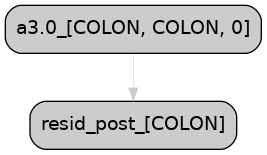

0 --------------------------------------------------
No edge 88
88
No edge 88
New metric: 0.0
No edge 88
No edge 88
No edge 88
We moved to  blocks.3.attn.hook_v[:, :, 0]
No edge 88


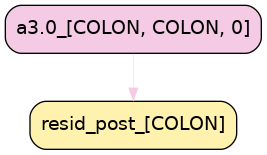

1 --------------------------------------------------
No edge 88
88
No edge 88
New metric: 0.0

Node: cur_parent=TLACDCInterpNode(blocks.3.hook_v_input, [:, :, 0]) (self.current_node=TLACDCInterpNode(blocks.3.attn.hook_v, [:, :, 0]))

Metric after removing connection to blocks.3.hook_v_input [:, :, 0] is 0.33333295583724976 (and current metric 0.0)
Result is 0.33333295583724976...so keeping connection
No edge 88
We moved to  blocks.3.attn.hook_k[:, :, 0]
No edge 88


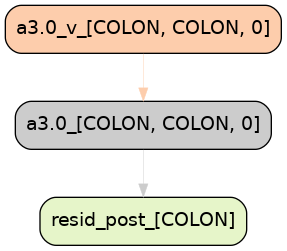

2 --------------------------------------------------
No edge 88
88
No edge 88
New metric: 0.0

Node: cur_parent=TLACDCInterpNode(blocks.3.hook_k_input, [:, :, 0]) (self.current_node=TLACDCInterpNode(blocks.3.attn.hook_k, [:, :, 0]))

Metric after removing connection to blocks.3.hook_k_input [:, :, 0] is 0.22916638851165771 (and current metric 0.0)
Result is 0.22916638851165771...so keeping connection
No edge 88
We moved to  blocks.3.attn.hook_q[:, :, 0]
No edge 88


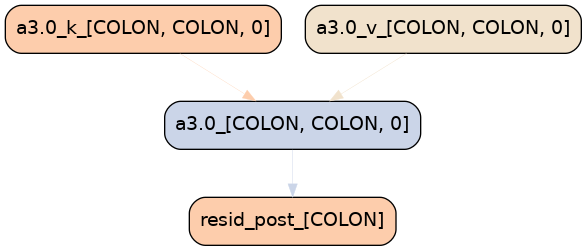

3 --------------------------------------------------
No edge 88
88
No edge 88
New metric: 0.0

Node: cur_parent=TLACDCInterpNode(blocks.3.hook_q_input, [:, :, 0]) (self.current_node=TLACDCInterpNode(blocks.3.attn.hook_q, [:, :, 0]))

Metric after removing connection to blocks.3.hook_q_input [:, :, 0] is 0.22916638851165771 (and current metric 0.0)
Result is 0.22916638851165771...so keeping connection
No edge 88


We moved to  blocks.3.hook_v_input[:, :, 0]
No edge 88


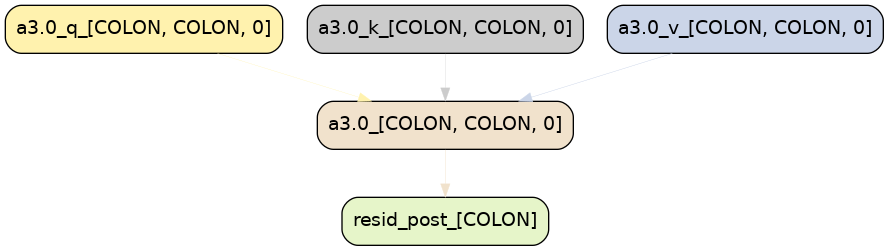

4 --------------------------------------------------
No edge 88
88
No edge 88
New metric: 0.0

Node: cur_parent=TLACDCInterpNode(blocks.2.hook_mlp_out, [:]) (self.current_node=TLACDCInterpNode(blocks.3.hook_v_input, [:, :, 0]))

Metric after removing connection to blocks.2.hook_mlp_out [:] is 0.0 (and current metric 0.0)
Result is 0.0...so removing connection
No edge 87

Node: cur_parent=TLACDCInterpNode(blocks.2.attn.hook_result, [:, :, 0]) (self.current_node=TLACDCInterpNode(blocks.3.hook_v_input, [:, :, 0]))

Metric after removing connection to blocks.2.attn.hook_result [:, :, 0] is 0.0 (and current metric 0.0)
Result is 0.0...so removing connection


No edge 86

Node: cur_parent=TLACDCInterpNode(blocks.1.hook_mlp_out, [:]) (self.current_node=TLACDCInterpNode(blocks.3.hook_v_input, [:, :, 0]))

Metric after removing connection to blocks.1.hook_mlp_out [:] is 0.0 (and current metric 0.0)
Result is 0.0...so removing connection
No edge 85

Node: cur_parent=TLACDCInterpNode(blocks.1.attn.hook_result, [:, :, 0]) (self.current_node=TLACDCInterpNode(blocks.3.hook_v_input, [:, :, 0]))

Metric after removing connection to blocks.1.attn.hook_result [:, :, 0] is 0.0 (and current metric 0.0)
Result is 0.0...so removing connection
No edge 84

Node: cur_parent=TLACDCInterpNode(blocks.0.hook_mlp_out, [:]) (self.current_node=TLACDCInterpNode(blocks.3.hook_v_input, [:, :, 0]))

Metric after removing connection to blocks.0.hook_mlp_out [:] is 0.0 (and current metric 0.0)
Result is 0.0...so removing connection
No edge 83

Node: cur_parent=TLACDCInterpNode(blocks.0.attn.hook_result, [:, :, 0]) (self.current_node=TLACDCInterpNode(blocks.3.hook_v_input, 

We moved to  blocks.3.hook_k_input[:, :, 0]
No edge 81


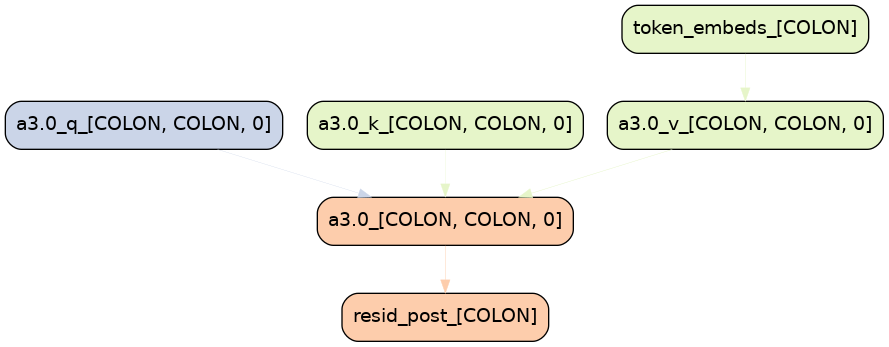

5 --------------------------------------------------
No edge 81
81
No edge 81
New metric: 0.0

Node: cur_parent=TLACDCInterpNode(blocks.2.hook_mlp_out, [:]) (self.current_node=TLACDCInterpNode(blocks.3.hook_k_input, [:, :, 0]))



Metric after removing connection to blocks.2.hook_mlp_out [:] is 0.0 (and current metric 0.0)
Result is 0.0...so removing connection
No edge 80

Node: cur_parent=TLACDCInterpNode(blocks.2.attn.hook_result, [:, :, 0]) (self.current_node=TLACDCInterpNode(blocks.3.hook_k_input, [:, :, 0]))

Metric after removing connection to blocks.2.attn.hook_result [:, :, 0] is 0.0 (and current metric 0.0)
Result is 0.0...so removing connection
No edge 79

Node: cur_parent=TLACDCInterpNode(blocks.1.hook_mlp_out, [:]) (self.current_node=TLACDCInterpNode(blocks.3.hook_k_input, [:, :, 0]))

Metric after removing connection to blocks.1.hook_mlp_out [:] is 0.0 (and current metric 0.0)
Result is 0.0...so removing connection


No edge 78

Node: cur_parent=TLACDCInterpNode(blocks.1.attn.hook_result, [:, :, 0]) (self.current_node=TLACDCInterpNode(blocks.3.hook_k_input, [:, :, 0]))

Metric after removing connection to blocks.1.attn.hook_result [:, :, 0] is 0.0 (and current metric 0.0)
Result is 0.0...so removing connection
No edge 77

Node: cur_parent=TLACDCInterpNode(blocks.0.hook_mlp_out, [:]) (self.current_node=TLACDCInterpNode(blocks.3.hook_k_input, [:, :, 0]))

Metric after removing connection to blocks.0.hook_mlp_out [:] is 0.0 (and current metric 0.0)
Result is 0.0...so removing connection
No edge 76

Node: cur_parent=TLACDCInterpNode(blocks.0.attn.hook_result, [:, :, 0]) (self.current_node=TLACDCInterpNode(blocks.3.hook_k_input, [:, :, 0]))

Metric after removing connection to blocks.0.attn.hook_result [:, :, 0] is 0.0 (and current metric 0.0)
Result is 0.0...so removing connection
No edge 75

Node: cur_parent=TLACDCInterpNode(hook_embed, [:]) (self.current_node=TLACDCInterpNode(blocks.3.hook_k_input, [

No edge 74


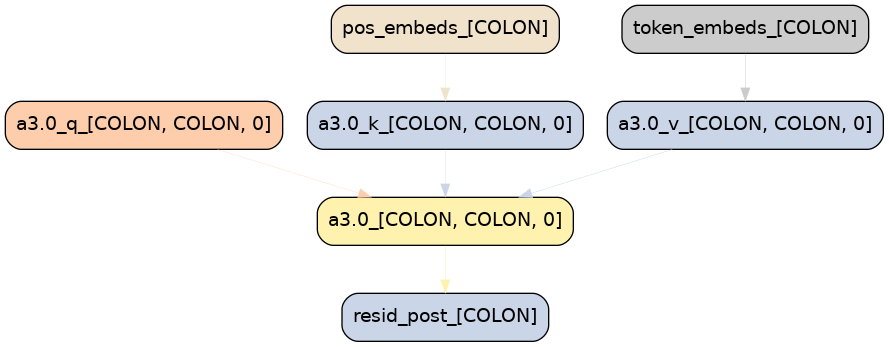

6 --------------------------------------------------
No edge 74
74


No edge 74
New metric: 1.1842378477584098e-13

Node: cur_parent=TLACDCInterpNode(blocks.2.hook_mlp_out, [:]) (self.current_node=TLACDCInterpNode(blocks.3.hook_q_input, [:, :, 0]))

Metric after removing connection to blocks.2.hook_mlp_out [:] is 0.22916638851165771 (and current metric 1.1842378477584098e-13)
Result is 0.22916638851153928...so keeping connection


No edge 74

Node: cur_parent=TLACDCInterpNode(blocks.2.attn.hook_result, [:, :, 0]) (self.current_node=TLACDCInterpNode(blocks.3.hook_q_input, [:, :, 0]))

Metric after removing connection to blocks.2.attn.hook_result [:, :, 0] is 1.1842378477584098e-13 (and current metric 1.1842378477584098e-13)
Result is 0.0...so removing connection
No edge 73

Node: cur_parent=TLACDCInterpNode(blocks.1.hook_mlp_out, [:]) (self.current_node=TLACDCInterpNode(blocks.3.hook_q_input, [:, :, 0]))

Metric after removing connection to blocks.1.hook_mlp_out [:] is 1.1842378477584098e-13 (and current metric 1.1842378477584098e-13)
Result is 0.0...so removing connection
No edge 72

Node: cur_parent=TLACDCInterpNode(blocks.1.attn.hook_result, [:, :, 0]) (self.current_node=TLACDCInterpNode(blocks.3.hook_q_input, [:, :, 0]))



Metric after removing connection to blocks.1.attn.hook_result [:, :, 0] is 1.1842378477584098e-13 (and current metric 1.1842378477584098e-13)
Result is 0.0...so removing connection
No edge 71

Node: cur_parent=TLACDCInterpNode(blocks.0.hook_mlp_out, [:]) (self.current_node=TLACDCInterpNode(blocks.3.hook_q_input, [:, :, 0]))

Metric after removing connection to blocks.0.hook_mlp_out [:] is 1.1842378477584098e-13 (and current metric 1.1842378477584098e-13)
Result is 0.0...so removing connection
No edge 70

Node: cur_parent=TLACDCInterpNode(blocks.0.attn.hook_result, [:, :, 0]) (self.current_node=TLACDCInterpNode(blocks.3.hook_q_input, [:, :, 0]))

Metric after removing connection to blocks.0.attn.hook_result [:, :, 0] is 1.1842378477584098e-13 (and current metric 1.1842378477584098e-13)
Result is 0.0...so removing connection
No edge 69

Node: cur_parent=TLACDCInterpNode(hook_embed, [:]) (self.current_node=TLACDCInterpNode(blocks.3.hook_q_input, [:, :, 0]))

Metric after removing connecti

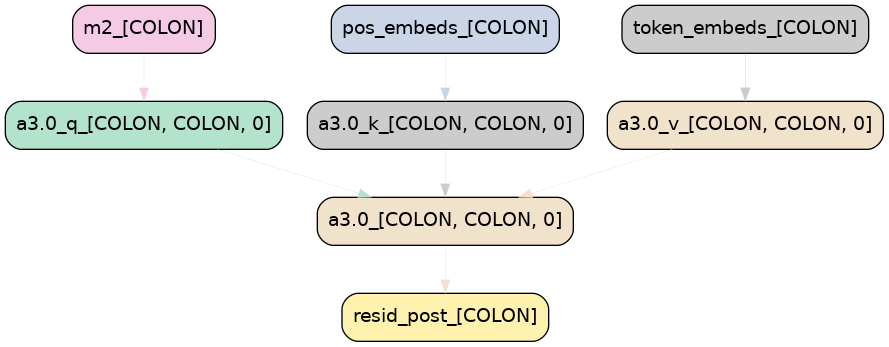

7 --------------------------------------------------
No edge 67
67


No edge 67
New metric: 1.1842378477584098e-13
No edge 67
We moved to  blocks.2.hook_mlp_in[:]


No edge 67


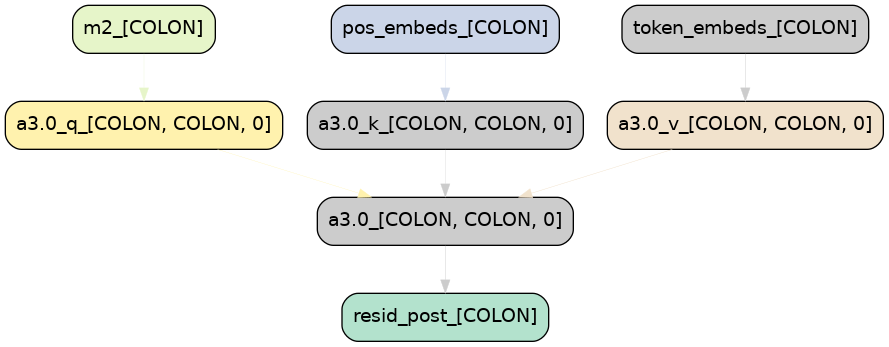

8 --------------------------------------------------
No edge 67
67
No edge 67
New metric: 1.1842378477584098e-13

Node: cur_parent=TLACDCInterpNode(blocks.2.attn.hook_result, [:, :, 0]) (self.current_node=TLACDCInterpNode(blocks.2.hook_mlp_in, [:]))

Metric after removing connection to blocks.2.attn.hook_result [:, :, 0] is 1.1842378477584098e-13 (and current metric 1.1842378477584098e-13)
Result is 0.0...so removing connection
No edge 66

Node: cur_parent=TLACDCInterpNode(blocks.1.hook_mlp_out, [:]) (self.current_node=TLACDCInterpNode(blocks.2.hook_mlp_in, [:]))

Metric after removing connection to blocks.1.hook_mlp_out [:] is 0.22916638851165771 (and current metric 1.1842378477584098e-13)
Result is 0.22916638851153928...so keeping connection
No edge 66

Node: cur_parent=TLACDCInterpNode(blocks.1.attn.hook_result, [:, :, 0]) (self.current_node=TLACDCInterpNode(blocks.2.hook_mlp_in, [:]))

Metric after removing connection to blocks.1.attn.hook_result [:, :, 0] is 1.1842378477584098e-13

We moved to  blocks.2.attn.hook_result[:, :, 0]


No edge 61
No edge 61
But it's bad
We moved to  blocks.2.attn.hook_v[:, :, 0]


No edge 61
No edge 60
But it's bad
We moved to  blocks.2.attn.hook_k[:, :, 0]
No edge 60
No edge 59
But it's bad
We moved to  blocks.2.attn.hook_q[:, :, 0]
No edge 59
No edge 58
But it's bad
We moved to  blocks.2.hook_v_input[:, :, 0]
No edge 58


No edge 52
But it's bad
We moved to  blocks.2.hook_k_input[:, :, 0]
No edge 52
No edge 46
But it's bad
We moved to  blocks.2.hook_q_input[:, :, 0]
No edge 46
No edge 40
But it's bad
We moved to  blocks.1.hook_mlp_out[:]
No edge 40


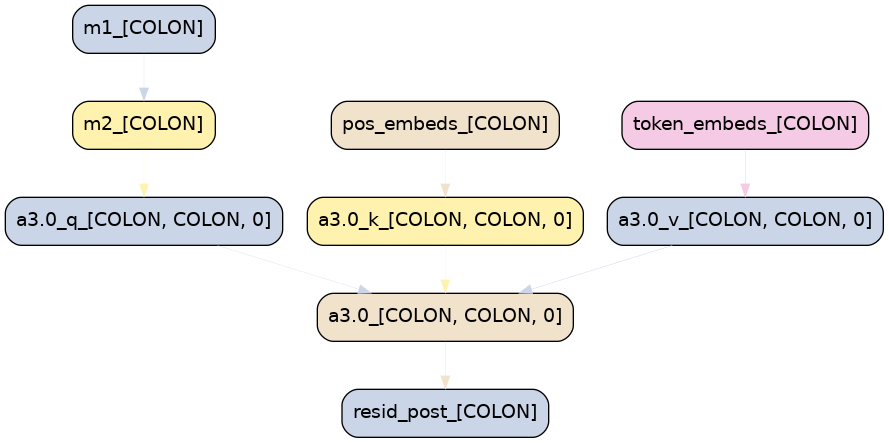

9 --------------------------------------------------
No edge 40
40
No edge 40
New metric: 1.1842378477584098e-13
No edge 40
We moved to  blocks.1.hook_mlp_in[:]
No edge 40


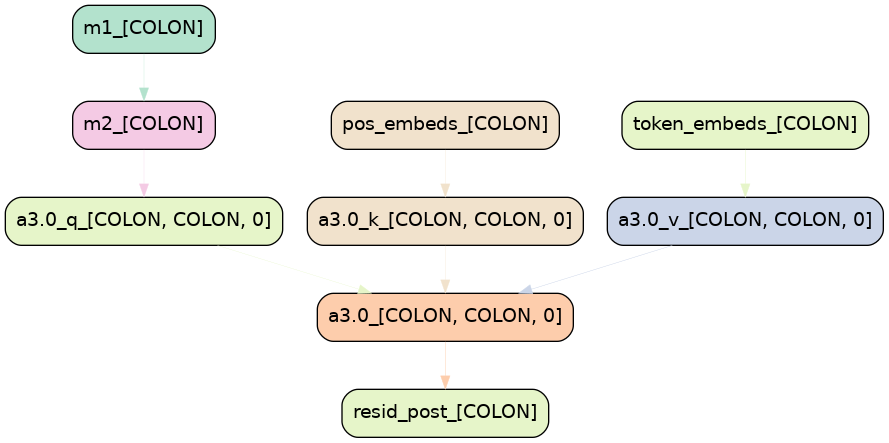

10 --------------------------------------------------
No edge 40
40


No edge 40
New metric: 1.1842378477584098e-13

Node: cur_parent=TLACDCInterpNode(blocks.1.attn.hook_result, [:, :, 0]) (self.current_node=TLACDCInterpNode(blocks.1.hook_mlp_in, [:]))

Metric after removing connection to blocks.1.attn.hook_result [:, :, 0] is 1.1842378477584098e-13 (and current metric 1.1842378477584098e-13)
Result is 0.0...so removing connection
No edge 39

Node: cur_parent=TLACDCInterpNode(blocks.0.hook_mlp_out, [:]) (self.current_node=TLACDCInterpNode(blocks.1.hook_mlp_in, [:]))

Metric after removing connection to blocks.0.hook_mlp_out [:] is 0.22916638851165771 (and current metric 1.1842378477584098e-13)
Result is 0.22916638851153928...so keeping connection
No edge 39

Node: cur_parent=TLACDCInterpNode(blocks.0.attn.hook_result, [:, :, 0]) (self.current_node=TLACDCInterpNode(blocks.1.hook_mlp_in, [:]))



Metric after removing connection to blocks.0.attn.hook_result [:, :, 0] is 1.1842378477584098e-13 (and current metric 1.1842378477584098e-13)
Result is 0.0...so removing connection
No edge 38

Node: cur_parent=TLACDCInterpNode(hook_embed, [:]) (self.current_node=TLACDCInterpNode(blocks.1.hook_mlp_in, [:]))

Metric after removing connection to hook_embed [:] is 0.22222194075584412 (and current metric 1.1842378477584098e-13)
Result is 0.22222194075572568...so keeping connection
No edge 38

Node: cur_parent=TLACDCInterpNode(hook_pos_embed, [:]) (self.current_node=TLACDCInterpNode(blocks.1.hook_mlp_in, [:]))

Metric after removing connection to hook_pos_embed [:] is 0.22916638851165771 (and current metric 1.1842378477584098e-13)
Result is 0.22916638851153928...so keeping connection
No edge 38
We moved to  blocks.1.attn.hook_result[:, :, 0]


No edge 38
No edge 38
But it's bad
We moved to  blocks.1.attn.hook_v[:, :, 0]
No edge 38
No edge 37
But it's bad
We moved to  blocks.1.attn.hook_k[:, :, 0]
No edge 37
No edge 36
But it's bad
We moved to  blocks.1.attn.hook_q[:, :, 0]
No edge 36
No edge 35
But it's bad
We moved to  blocks.1.hook_v_input[:, :, 0]
No edge 35
No edge 31
But it's bad
We moved to  blocks.1.hook_k_input[:, :, 0]
No edge 31


No edge 27
But it's bad
We moved to  blocks.1.hook_q_input[:, :, 0]


No edge 27
No edge 23
But it's bad
We moved to  blocks.0.hook_mlp_out[:]
No edge 23


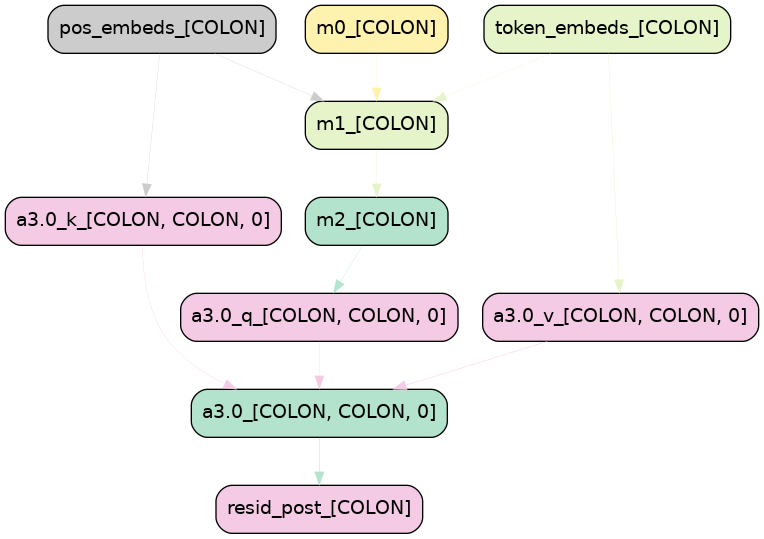

11 --------------------------------------------------
No edge 23
23
No edge 23
New metric: 1.1842378477584098e-13
No edge 23
We moved to  blocks.0.hook_mlp_in[:]
No edge 23


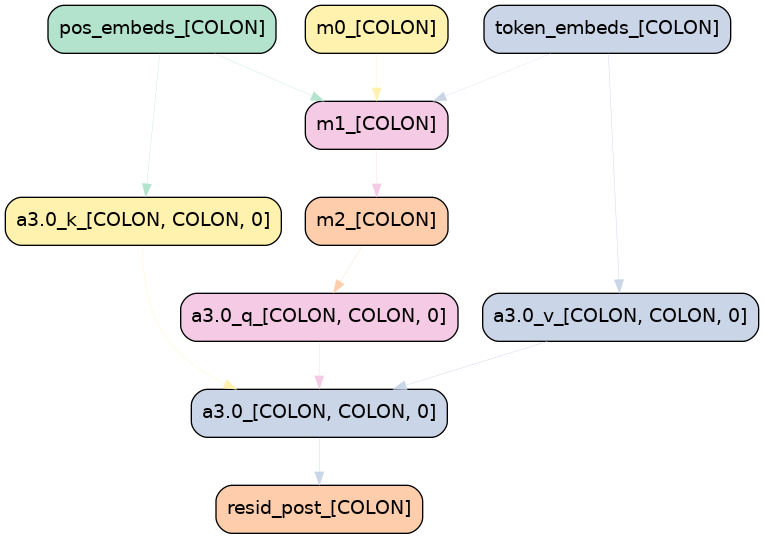

12 --------------------------------------------------
No edge 23
23
No edge 23
New metric: 1.1842378477584098e-13

Node: cur_parent=TLACDCInterpNode(blocks.0.attn.hook_result, [:, :, 0]) (self.current_node=TLACDCInterpNode(blocks.0.hook_mlp_in, [:]))

Metric after removing connection to blocks.0.attn.hook_result [:, :, 0] is 0.37499967217445374 (and current metric 1.1842378477584098e-13)
Result is 0.37499967217433533...so keeping connection
No edge 23

Node: cur_parent=TLACDCInterpNode(hook_embed, [:]) (self.current_node=TLACDCInterpNode(blocks.0.hook_mlp_in, [:]))

Metric after removing connection to hook_embed [:] is 0.22916638851165771 (and current metric 1.1842378477584098e-13)
Result is 0.22916638851153928...so keeping connection
No edge 23

Node: cur_parent=TLACDCInterpNode(hook_pos_embed, [:]) (self.current_node=TLACDCInterpNode(blocks.0.hook_mlp_in, [:]))

Metric after removing connection to hook_pos_embed [:] is 1.1842378477584098e-13 (and current metric 1.1842378477584098e-13

No edge 22


We moved to  blocks.0.attn.hook_result[:, :, 0]
No edge 22


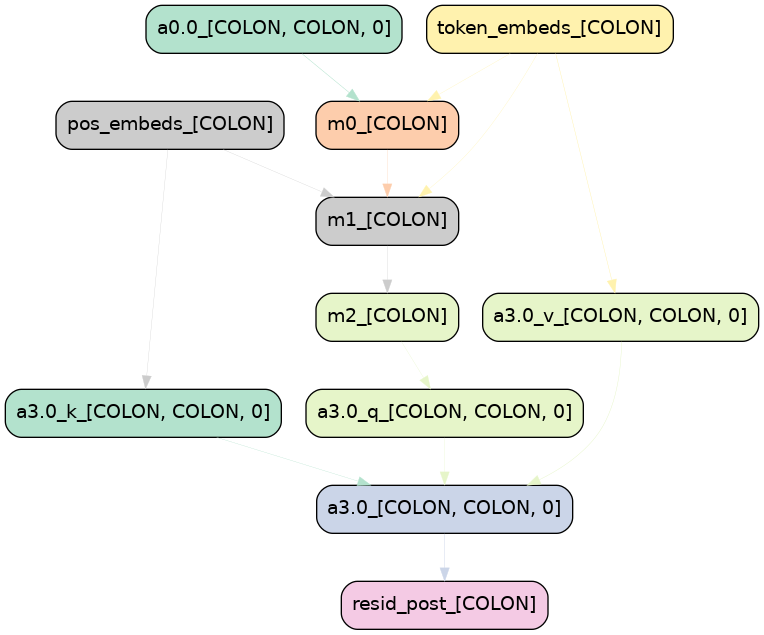

13 --------------------------------------------------
No edge 22
22
No edge 22
New metric: 1.1842378477584098e-13
No edge 22


No edge 22
No edge 22
We moved to  blocks.0.attn.hook_v[:, :, 0]
No edge 22


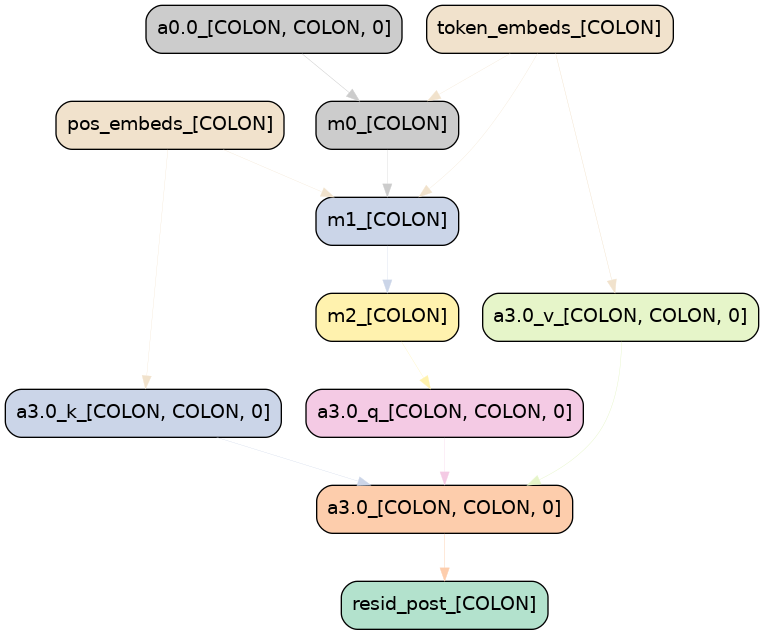

14 --------------------------------------------------
No edge 22
22
No edge 22
New metric: 1.1842378477584098e-13

Node: cur_parent=TLACDCInterpNode(blocks.0.hook_v_input, [:, :, 0]) (self.current_node=TLACDCInterpNode(blocks.0.attn.hook_v, [:, :, 0]))

Metric after removing connection to blocks.0.hook_v_input [:, :, 0] is 0.37499967217445374 (and current metric 1.1842378477584098e-13)
Result is 0.37499967217433533...so keeping connection
No edge 22


We moved to  blocks.0.attn.hook_k[:, :, 0]
No edge 22


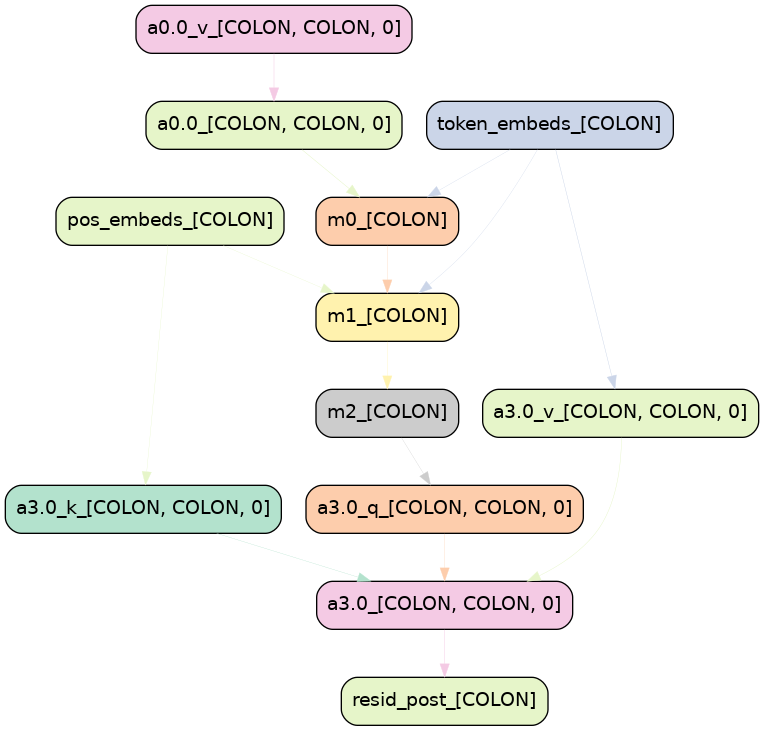

15 --------------------------------------------------
No edge 22
22
No edge 22
New metric: 1.1842378477584098e-13

Node: cur_parent=TLACDCInterpNode(blocks.0.hook_k_input, [:, :, 0]) (self.current_node=TLACDCInterpNode(blocks.0.attn.hook_k, [:, :, 0]))

Metric after removing connection to blocks.0.hook_k_input [:, :, 0] is 1.1842378477584098e-13 (and current metric 1.1842378477584098e-13)
Result is 0.0...so removing connection
No edge 21
We moved to  blocks.0.attn.hook_q[:, :, 0]
No edge 21


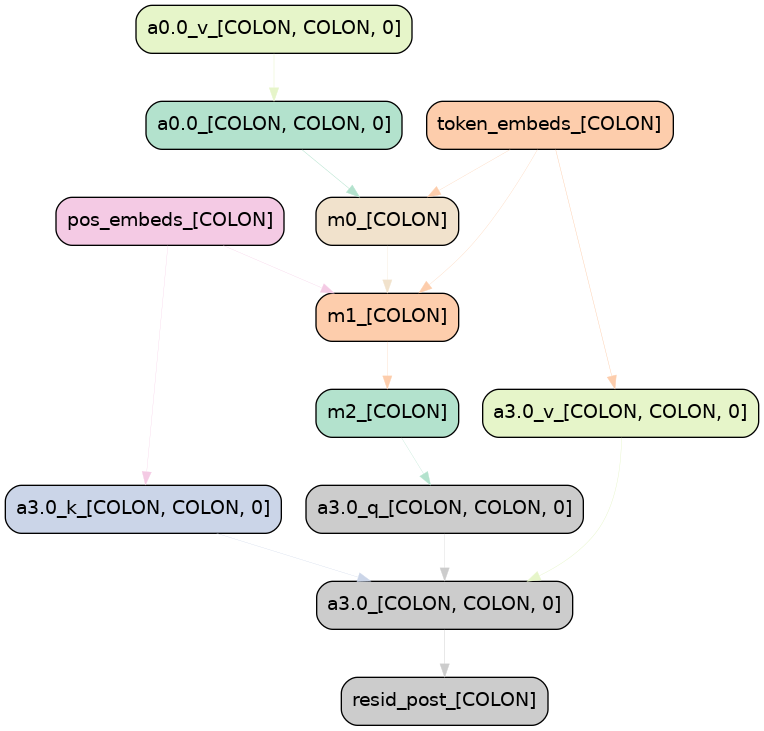

16 --------------------------------------------------
No edge 21
21
No edge 21
New metric: 1.1842378477584098e-13

Node: cur_parent=TLACDCInterpNode(blocks.0.hook_q_input, [:, :, 0]) (self.current_node=TLACDCInterpNode(blocks.0.attn.hook_q, [:, :, 0]))

Metric after removing connection to blocks.0.hook_q_input [:, :, 0] is 1.1842378477584098e-13 (and current metric 1.1842378477584098e-13)
Result is 0.0...so removing connection
No edge 20
We moved to  blocks.0.hook_v_input[:, :, 0]


No edge 20


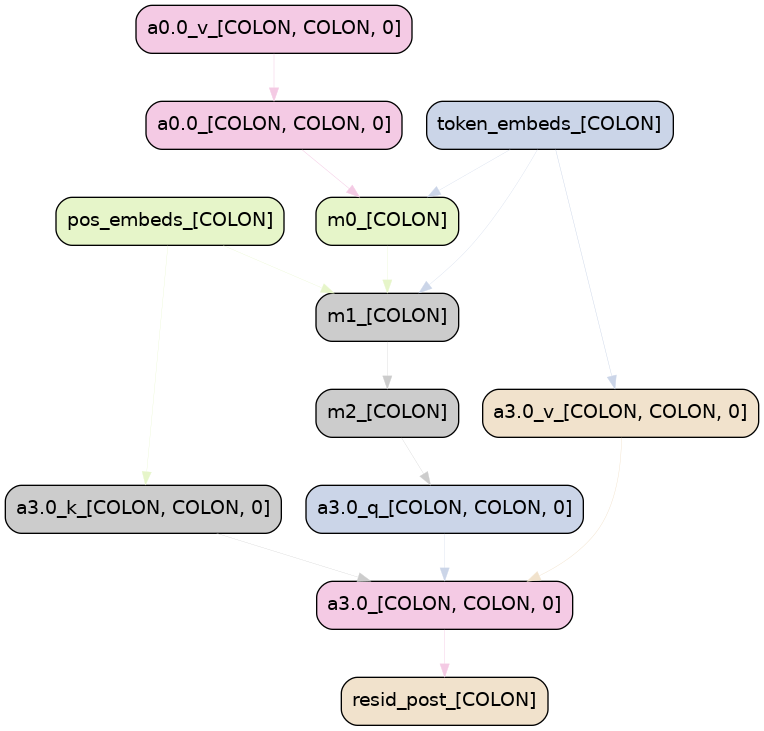

17 --------------------------------------------------
No edge 20
20


No edge 20
New metric: 1.1842378477584098e-13

Node: cur_parent=TLACDCInterpNode(hook_embed, [:]) (self.current_node=TLACDCInterpNode(blocks.0.hook_v_input, [:, :, 0]))

Metric after removing connection to hook_embed [:] is 0.37499967217445374 (and current metric 1.1842378477584098e-13)
Result is 0.37499967217433533...so keeping connection
No edge 20

Node: cur_parent=TLACDCInterpNode(hook_pos_embed, [:]) (self.current_node=TLACDCInterpNode(blocks.0.hook_v_input, [:, :, 0]))

Metric after removing connection to hook_pos_embed [:] is 1.1842378477584098e-13 (and current metric 1.1842378477584098e-13)
Result is 0.0...so removing connection
No edge 19
We moved to  blocks.0.hook_k_input[:, :, 0]


No edge 19
No edge 17
But it's bad
We moved to  blocks.0.hook_q_input[:, :, 0]
No edge 17
No edge 15
But it's bad
We moved to  hook_pos_embed[:]


No edge 15


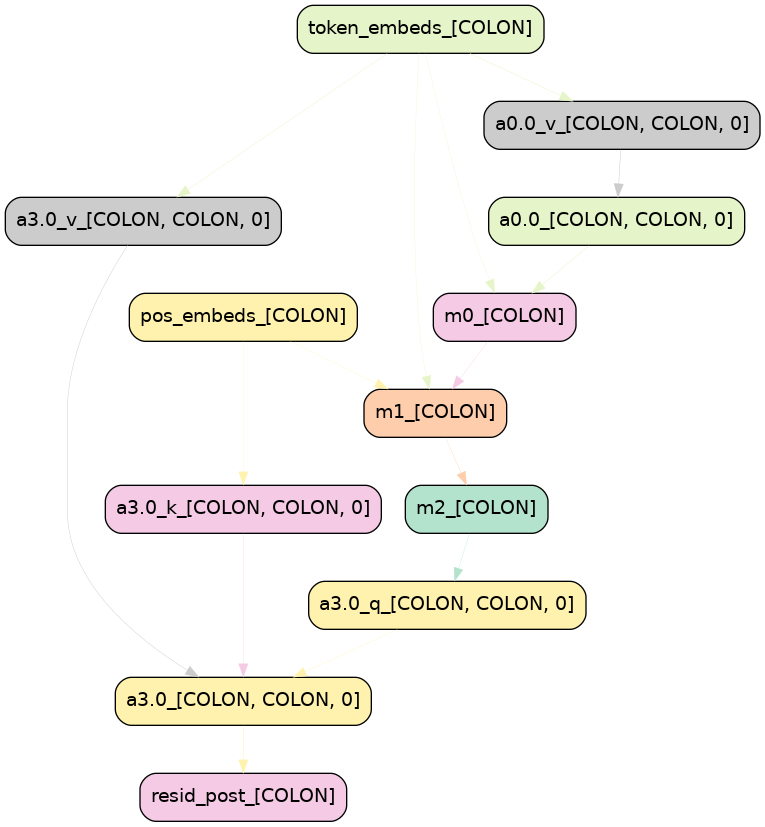

18 --------------------------------------------------
No edge 15
15
No edge 15
New metric: 1.1842378477584098e-13
We moved to  hook_embed[:]
No edge 15


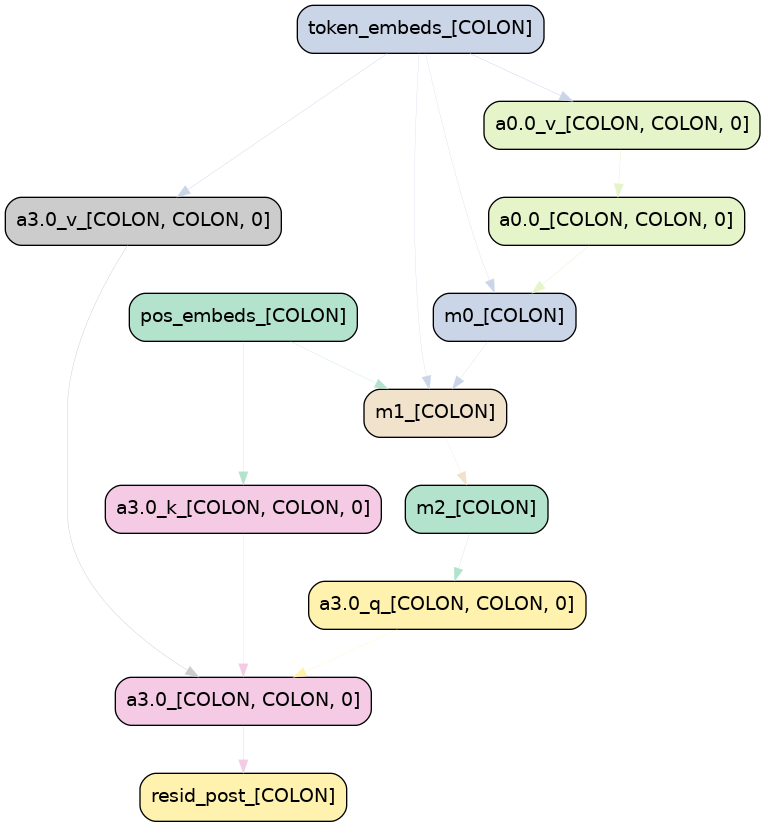

19 --------------------------------------------------
No edge 15
15


No edge 15
New metric: 1.1842378477584098e-13
We moved to  None
No edge 15


/root/Automatic-Circuit-Discovery/acdc/TLACDCExperiment.py:716: UserWarning:

Finished iterating



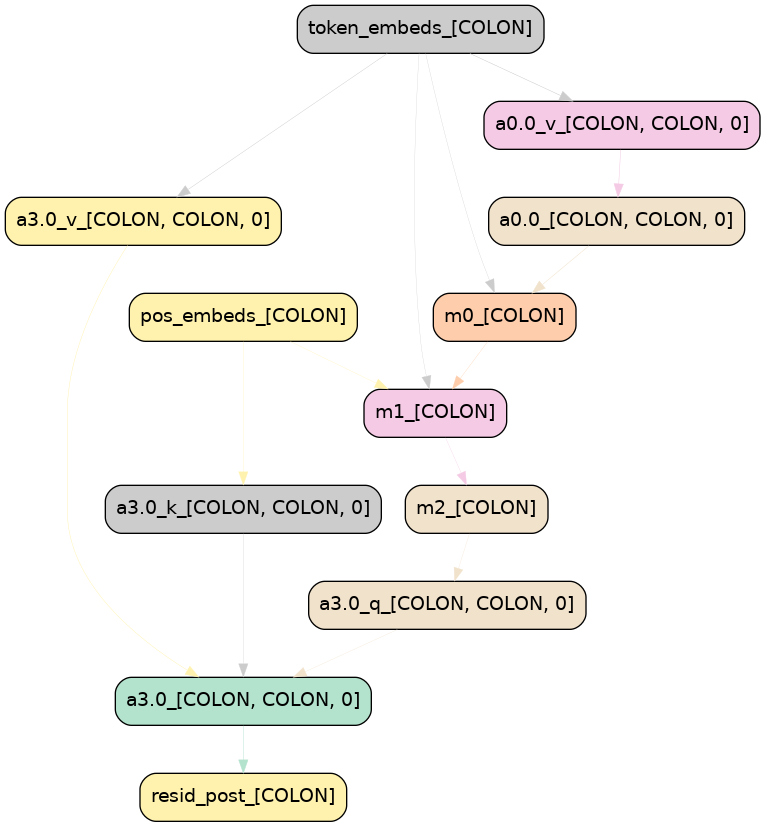

20 --------------------------------------------------
No edge 15
15


In [6]:
for i in range(args.max_num_epochs):
    exp.step(testing=False)

    show(
        exp.corr,
        f"ims/img_new_{i+1}.png",
        show_full_index=use_pos_embed,
    )

    if IN_COLAB or ipython is not None:
        # so long as we're not running this as a script, show the image!
        display(Image(f"ims/img_new_{i+1}.png"))

    print(i, "-" * 50)
    print(exp.count_no_edges())

    if i == 0:
        exp.save_edges("edges.pkl")

    if exp.current_node is None or SINGLE_STEP:
        break

exp.save_edges("another_final_edges.pkl")

if USING_WANDB:
    edges_fname = f"edges.pth"
    exp.save_edges(edges_fname)
    artifact = wandb.Artifact(edges_fname, type="dataset")
    artifact.add_file(edges_fname)
    wandb.log_artifact(artifact)
    os.remove(edges_fname)
    wandb.finish()

<h2>Save the final subgraph of the model</h2>
<p>There are more than `exp.count_no_edges()` here because we include some "placeholder" edges needed to make ACDC work that don't actually matter</p>
<p>Also note that the final image has more than 12 edges, because the edges from a0.0_q and a0.0_k are not connected to the input</p>
<p>We recover minimal induction machinery! `embed -> a0.0_v -> a1.6k`</p>

In [7]:
exp.save_subgraph(
    return_it=True,
) 

OrderedDict([(('blocks.3.hook_resid_post',
               (None,),
               'blocks.3.attn.hook_result',
               (None, None, 0)),
              True),
             (('blocks.3.attn.hook_result',
               (None, None, 0),
               'blocks.3.attn.hook_q',
               (None, None, 0)),
              True),
             (('blocks.3.attn.hook_result',
               (None, None, 0),
               'blocks.3.attn.hook_k',
               (None, None, 0)),
              True),
             (('blocks.3.attn.hook_result',
               (None, None, 0),
               'blocks.3.attn.hook_v',
               (None, None, 0)),
              True),
             (('blocks.3.attn.hook_q',
               (None, None, 0),
               'blocks.3.hook_q_input',
               (None, None, 0)),
              True),
             (('blocks.3.attn.hook_k',
               (None, None, 0),
               'blocks.3.hook_k_input',
               (None, None, 0)),
              True)